In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import pandas as pd
import numpy as np
import requests
from PIL import Image
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from marketplace_assistant.config import RAW_IMAGE_FILE_DIR, PROCESSED_DATA_DIR

# Using Image-to-Text Model to Caption Images

https://github.com/vikhyat/moondream

In [3]:
model_id = "vikhyatk/moondream2"
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True
).to("mps")
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [4]:
marketplace_data_path = PROCESSED_DATA_DIR / "marketplace_data.csv"
marketplace_data = pd.read_csv(marketplace_data_path, )

marketplace_data.sample(5)

,brand,bullet_point,item_id,item_name,product_type,main_image_id,other_image_id,path
56084,Stone & Beam,NaN,B075JQYVPX,Stone & Beam Medaillonteppich Mid-Century Mode...,HOME_FURNITURE_AND_DECOR,A194kPVvFmL,"['91BSu0qrBxL', 'A10sbjnmCZL', 'B1QJINggHqS', ...",f5/f54cda07.jpg
22347,AmazonBasics,NaN,B07PYL8KFT,AmazonBasics Poly Linear-Rib Commercial Carpet...,JANITORIAL_SUPPLY,91AX6REm4DL,NaN,bc/bcc50c4c.jpg
67527,Wickedly Prime (ウィキッドリープライム),原材料:かき(広島県)、大豆油、食塩; 商品サイズ(高さx奥行x幅):8cm×3.5cm×8cm,B07C9P2GGN,[Amazonブランド]Wickedly Prime Premiumおつまみ 広島県産 かき...,GROCERY,51z2bchLhuL,NaN,ba/ba0a7160.jpg
91705,Amazon Brand - Solimo,3D Printed Hard Back Case Mobile Cover for Sam...,B07TH33DXS,Amazon Brand - Solimo Designer Brush Art 3D Pr...,CELLULAR_PHONE_CASE,71fYdXMJp+L,"['61oI69Yt4GL', '61Xce1Hq7DL', '61ATVyzpLKL', ...",20/202bef71.jpg
65942,AmazonBasics,NaN,B079VPHBHH,AmazonBasics – Bombilla LED A19,LIGHT_BULB,71t13gdNCwL,"['51PFODvS-iL', '81okaYx67vL', '41bzKhec-0L']",8e/8e12dc81.jpg


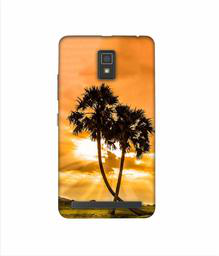

Amazon Brand - Solimo Designer SunSide View 3D Printed Hard Back Case Mobile Cover for Lenovo A6600


In [5]:
img_sample = marketplace_data.sample(1)
img_file = img_sample["path"].item()
img_desc = img_sample["item_name"].item()
img = Image.open(RAW_IMAGE_FILE_DIR / img_file)

display(img)
print(img_desc)


In [6]:
enc_image = model.encode_image(img)
print(model.answer_question(enc_image, "Describe this image.", tokenizer))

The image features a phone case with a palm tree silhouette against a sunset sky, with the palm tree's trunk and leaves in the foreground and the sun's rays peeking through the clouds in the background.


# Batched inference
Pass a list of image paths for batched inference

In [36]:
batch_size = 2
batch_sample = marketplace_data.sample(4)
data_len = len(batch_sample)

ans = []

for chunk in np.array_split(batch_sample, data_len / batch_size):
  chunk['full_path'] = str(RAW_IMAGE_FILE_DIR) + '/' + chunk['path'].astype(str)
  chunk_imgs = chunk['full_path'].tolist()
  chunk_imgs = [Image.open(name) for name in chunk_imgs]
  prompt = ["Thoroughly describe the object in the image in a concise manner."] * len(chunk)
  ans = ans + model.batch_answer(images=chunk_imgs, prompts = prompt, tokenizer = tokenizer)

batch_sample['ai_desc'] = ans

batch_sample

/Users/ashvath/anaconda3/envs/marketplace_assistant_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,brand,bullet_point,item_id,item_name,product_type,main_image_id,other_image_id,path,ai_desc
70535,Stone & Beam,"This item is made to order just for you; 29""W ...",B075X4N3QL,"스톤 & 빔 마린 스터드 소파; Stone & Beam Marin 饰钉沙发, 灰石色...",HOME_FURNITURE_AND_DECOR,81YK+FCCDUL,"['91XuBjzOe4L', '8120sG8i5SL', 'A1+dw4szFzL', ...",a5/a5266398.jpg,The image features a white ottoman with a squa...
43985,Allegro Coffee,20 count Green Tea Bags; Contains caffeine; OR...,B008LX1TLM,"Allegro Tea, Organic Jasmine Green Tea Bags, 2...",TEA,71063bu8fpL,"['91tOsZHGF2L', '812WHT0fBcL', '81epRjnLTcL', ...",91/918b974a.jpg,"The image features a box of Allegro Tea, speci..."
57047,Amazon Essentials,Oui.,B07W4FT436,"Amazon Essentials Aeron Fashion-Sneakers, Noir...",SHOES,618E+DoaOZL,"['61kGLwJJnOL', '61fg6wpwJsL', '61X7MDeSLeL', ...",8e/8eb92955.jpg,The image features a black and white sneaker w...
47871,AmazonBasics,Satin Nickel finish; made from durable zinc al...,B0775YFK3P,AmazonBasics Modern Bathroom Accessories Set -...,TOWEL_HOLDER,71cjBv3aQKL,"['61B5AE2aZWL', '6191Xm+42IL', '51WM5DOF4HL', ...",6b/6ba750e8.jpg,The image features a set of silver-colored bat...


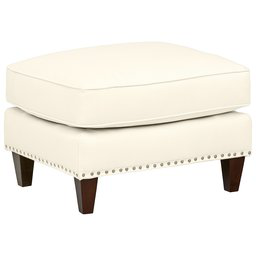

The image features a white ottoman with a square top and a round base, adorned with wooden legs and studded details.


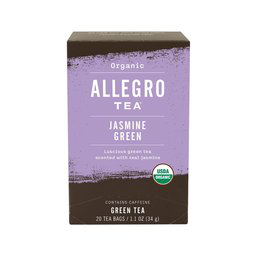

The image features a box of Allegro Tea, specifically Jasmine Green, with a purple label. The box contains 20 tea bags, each weighing 1.1 oz (34g). The tea is described as a "Luscious green tea" and is made with "Organic" ingredients.


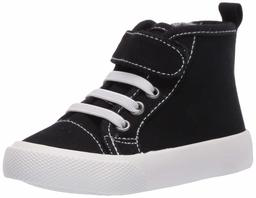

The image features a black and white sneaker with white laces and a white sole, positioned on a white background.


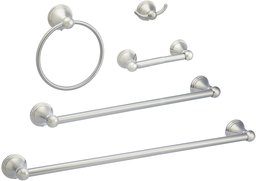

The image features a set of silver-colored bathroom accessories, including a towel ring, towel bars, and a towel rack.


In [37]:
for index, row in batch_sample.iterrows():
    image = Image.open(RAW_IMAGE_FILE_DIR / row["path"])
    display(image)
    print(row["ai_desc"])
    